In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
from scipy import optimize
dp = '/home/ebert/jupyter-notebooks/FNode-data'

def rfe_nd_np(x, a, f, b):
    return b + a*np.cos(2*np.pi*f*x)

def rfe_nd(x, a, f, phi, b):
    return b + a*np.cos(2*np.pi*f*x+phi)

def rfe(x, a, f, phi, b, tau):
    return b + a*np.cos(2*np.pi*f*x+phi)*np.exp(-x/tau)

def rfe_pow(x, a, f, phi, b, tau, p):
    return b + a*np.cos(2*np.pi*f*x+phi)*np.exp(-np.power(x/tau,p))

def rfe_huh(x, a, f, b, tau):
    return b + a*np.exp(-x/tau)*(np.cos(np.pi*f*x)**2-0.5)

name 'fort_exp' is not defined
name 'rb_uwave_freq' is not defined
ivars: [u'uwave_phase']
ivar: 0.0000	cloading: 0.122	rloading: 0.265		cretention: 0.695 +- 0.022	rretention: 0.939 +- 0.011
ivar: 0.2000	cloading: 0.118	rloading: 0.228		cretention: 0.675 +- 0.023	rretention: 0.860 +- 0.017
ivar: 0.4000	cloading: 0.160	rloading: 0.281		cretention: 0.576 +- 0.024	rretention: 0.660 +- 0.024
ivar: 0.6000	cloading: 0.147	rloading: 0.370		cretention: 0.384 +- 0.016	rretention: 0.361 +- 0.021
ivar: 0.8000	cloading: 0.112	rloading: 0.322		cretention: 0.265 +- 0.012	rretention: 0.103 +- 0.012
ivar: 1.0000	cloading: 0.092	rloading: 0.272		cretention: 0.172 +- 0.009	rretention: 0.014 +- 0.005
ivar: 1.2000	cloading: 0.174	rloading: 0.240		cretention: 0.126 +- 0.017	rretention: 0.072 +- 0.015
ivar: 1.4000	cloading: 0.153	rloading: 0.295		cretention: 0.199 +- 0.015	rretention: 0.324 +- 0.023
ivar: 1.6000	cloading: 0.126	rloading: 0.300		cretention: 0.305 +- 0.015	rretention: 0.568 +- 0.022
ivar: 1.8

<IPython.core.display.Javascript object>


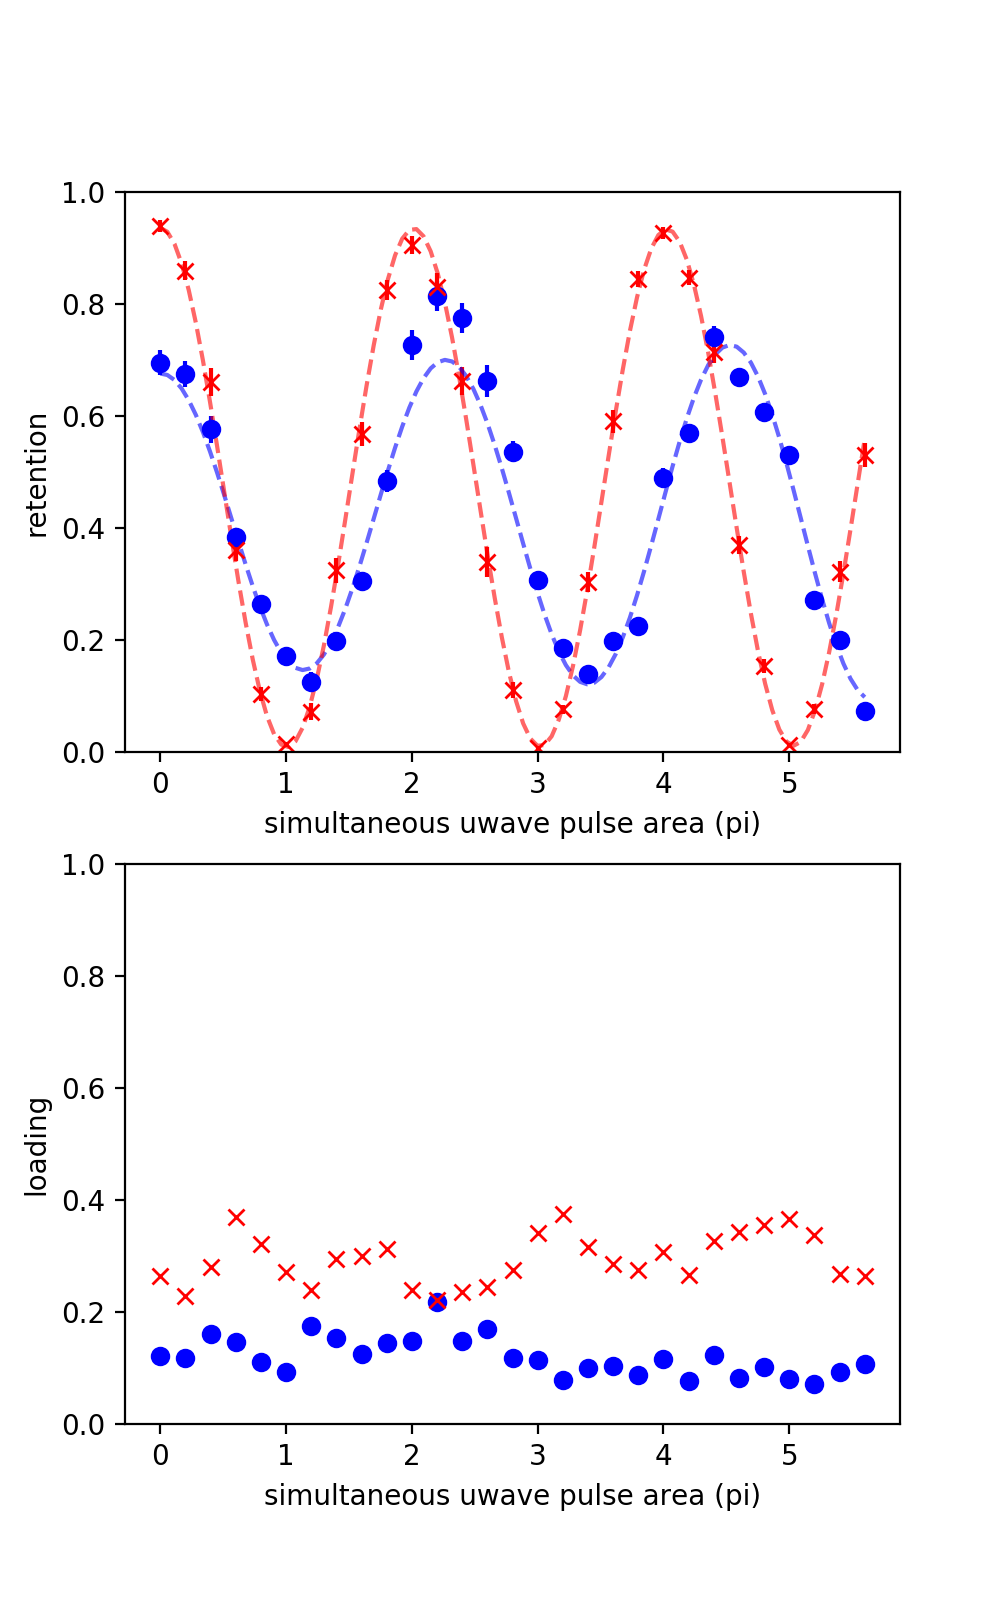

[  0.51760266   0.44187137   0.41704627 -25.17369721]
[  9.28090398e-01   4.96506364e-01   4.72105397e-01   7.50890459e+02]


In [25]:
exp_name = '2018_04_01_16_48_53_rbcs-rfe'
if exp_name:
    exp_date = '_'.join(exp_name.split('_')[:3])
    experiment_file = os.path.join(exp_date, exp_name, 'results.hdf5')
else:
    experiment_file = ''
q = qdp.QDP(base_data_path=dp)
q.load_data_file(experiment_file)
print "ivars: {}".format(q.experiments[0]['variable_list'])
cs_cuts = [[20],[3]]
rb_cuts = [[31],[3]]
q.set_thresholds(cs_cuts, roi=0)
q.set_thresholds(rb_cuts, roi=1)
retention = q.apply_thresholds()
cuts = q.get_thresholds()
roi_map = ['cs', 'rb']
fmt_map = ['bo', 'rx']
entries = np.product(retention['retention'].shape[:-1])
tbl_str = "ivar: {0:.4f}\tcloading: {1:.3f}\trloading: {2:.3f}\t\tcretention: {3:.3f} +- {4:.3f}\trretention: {5:.3f} +- {6:.3f}"
for i in range(entries):
    print(tbl_str.format(
        retention['ivar'].reshape((entries,-1))[i][0],
        retention['loading'].reshape((entries,-1))[i][0], retention['loading'].reshape((entries,-1))[i][1],
        retention['retention'].reshape((entries,-1))[i][0], retention['error'].reshape((entries,-1))[i][0],
        retention['retention'].reshape((entries,-1))[i][1], retention['error'].reshape((entries,-1))[i][1]
    ))
q.save_experiment_data()
xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']

# plotting
fig, ax = plt.subplots(nrows=2, figsize=(5,8))
plt.subplots_adjust(wspace=0.3)
for i, yvals in enumerate(['retention', 'loading']):
    for e in range(len(retention['ivar'])):
        for r in range(2):
            if yvals=='retention':
                try:
                    ax[i].errorbar(retention['ivar'][e, :, r], retention[yvals][e, :, r],
                        yerr=retention['error'][e,:,r], fmt=fmt_map[r]
                    )
                except Exception as ee:
                    print(ee)
                    ax[i].plot(retention['ivar'][e, :, 0], retention[yvals][e, :, r], fmt_map[r])
                # fitting
                xs = np.linspace(min(retention['ivar'][e, :, 0]), max(retention['ivar'][e, :, 0]),100)
                guess = [0.8, 0.5, 0.5, 10]
                try:
                    popt, pcov = optimize.curve_fit(
                        rfe_huh,
                        retention['ivar'][e, :, 0],
                        retention[yvals][e, :, r],
                        p0=guess,
                        sigma=retention['error'][e, :, r]
                    )
                except Exception as ee:
                    print ee
                else:
                    ax[i].plot(xs, rfe_huh(xs, *popt), fmt_map[r][0]+'--', alpha=0.6)
                    print(popt)
            else:
                ax[i].plot(retention['ivar'][e, :, 0], retention[yvals][e, :, r], fmt_map[r])
        
    ax[i].set_ylim(0, 1.0)
    ax[i].set_xlabel(xlab)
    ax[i].set_ylabel(yvals)

fmts = ['pdf', 'png']
fn = os.path.join(dp, q.experiments[0]['source_path'], 'rfe_scan.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

In [25]:
arange(0,4,0.25)

0.09004734242629955

In [8]:
(4.82832834e-01/0.5)*5.216743118170196

5.0376297279922255

In [7]:
( 0.54126158/0.5)*5.056946508783993

5.474261714639816

<IPython.core.display.Javascript object>


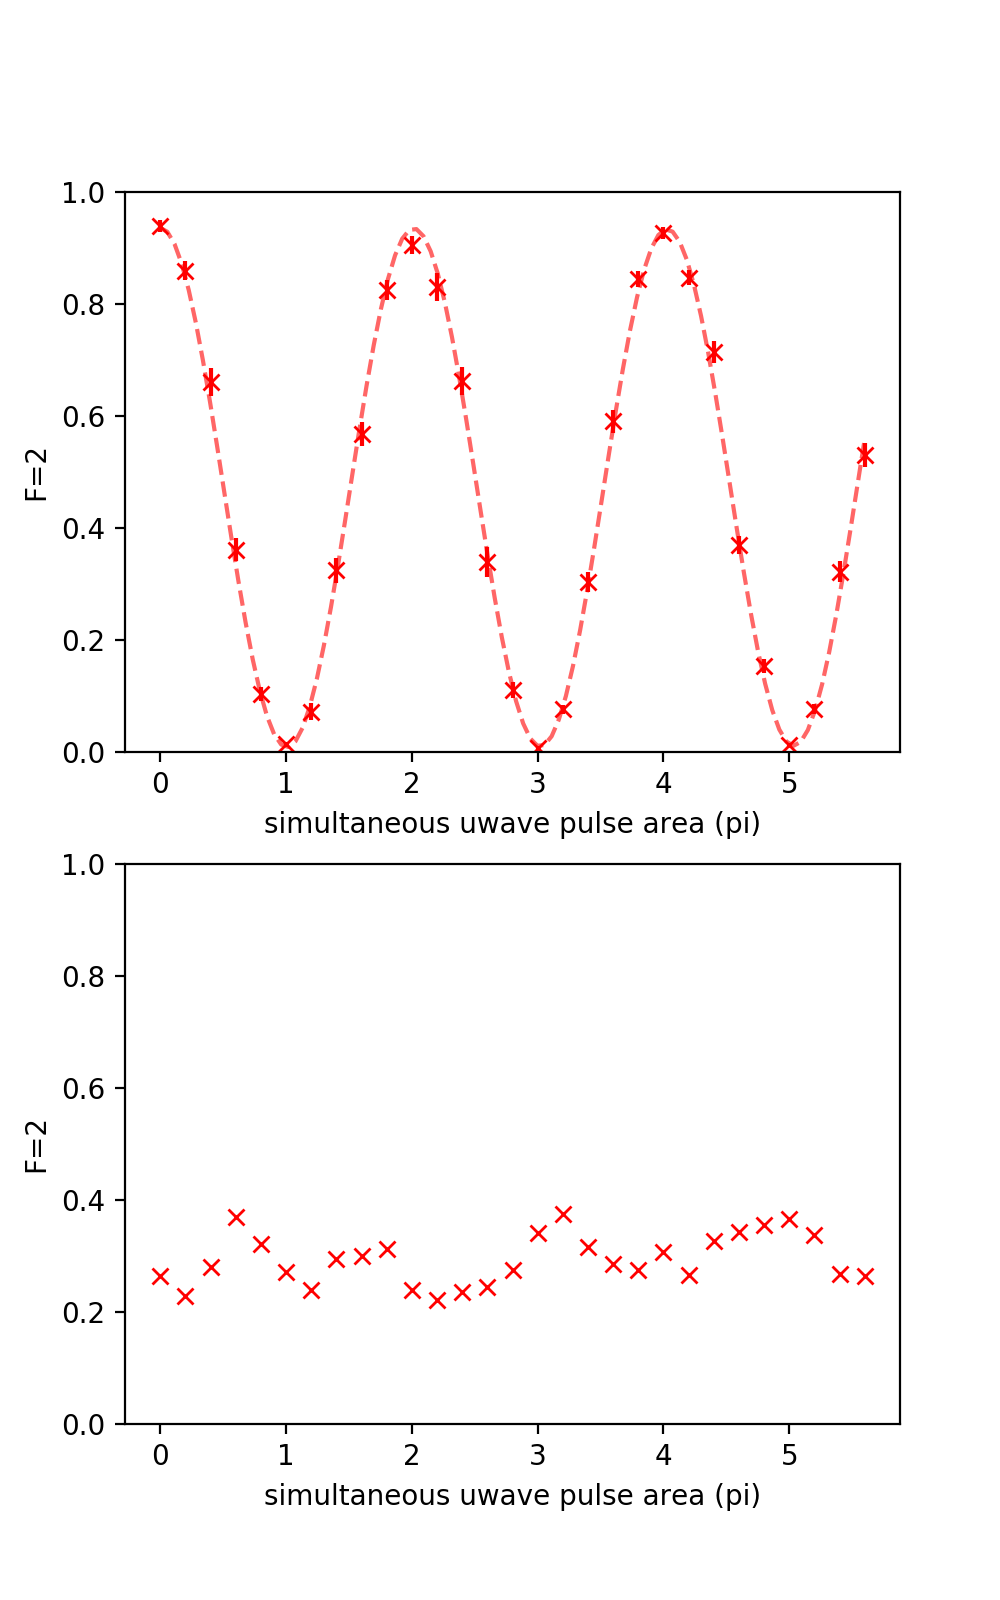

[  9.28090398e-01   4.96506364e-01   4.72105397e-01   7.50890459e+02]


In [27]:
# plotting
fig, ax = plt.subplots(nrows=2, figsize=(5,8))
plt.subplots_adjust(wspace=0.3)
for i, yvals in enumerate(['retention', 'loading']):
    for e in range(len(retention['ivar'])):
        for r in range(1,2):
            if yvals=='retention':
                try:
                    ax[i].errorbar(retention['ivar'][e, :, r], retention[yvals][e, :, r],
                        yerr=retention['error'][e,:,r], fmt=fmt_map[r]
                    )
                except Exception as ee:
                    print(ee)
                    ax[i].plot(retention['ivar'][e, :, 0], retention[yvals][e, :, r], fmt_map[r])
                # fitting
                xs = np.linspace(min(retention['ivar'][e, :, 0]), max(retention['ivar'][e, :, 0]),100)
                guess = [0.8, 0.5, 0.5, 10]
                try:
                    popt, pcov = optimize.curve_fit(
                        rfe_huh,
                        retention['ivar'][e, :, 0],
                        retention[yvals][e, :, r],
                        p0=guess,
                        sigma=retention['error'][e, :, r]
                    )
                except Exception as ee:
                    print ee
                else:
                    ax[i].plot(xs, rfe_huh(xs, *popt), fmt_map[r][0]+'--', alpha=0.6)
                    print(popt)
            else:
                ax[i].plot(retention['ivar'][e, :, 0], retention[yvals][e, :, r], fmt_map[r])
        
    ax[i].set_ylim(0, 1.0)
    ax[i].set_xlabel(xlab)
    ax[i].set_ylabel('F=2')

fmts = ['pdf', 'png']
fn = os.path.join(dp, q.experiments[0]['source_path'], 'rfe_scan.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

<IPython.core.display.Javascript object>


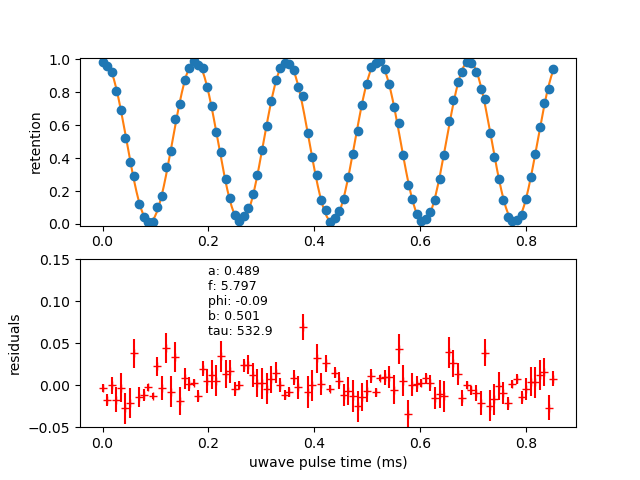

[  4.89029764e-01   5.79685897e+00  -9.20629219e-02   5.00840037e-01
   5.32926504e+02]


In [25]:
fig, ax = plt.subplots(2)
for e in range(len(retention['ivar'])):
    ax[0].errorbar(retention['ivar'][e], retention['retention'][e],
                yerr=retention['error'][e],
                fmt = 'o'
    )
ax[0].set_ylim(-0.01, 1.01)
ax[1].set_ylim(-0.05, 0.15)

ax[1].set_xlabel(xlab)

guess = [0.45, 5.7, 0, 0.5, 10]
for e in range(len(retention['ivar'])):
    popt, pcov = optimize.curve_fit(
        rfe,
        retention['ivar'][e],
        retention['retention'][e],
        p0=guess,
        sigma=retention['error'][e]
    )
    xs = np.linspace(min(retention['ivar'][e]),max(retention['ivar'][e]),200)
    ax[0].plot(xs, rfe(xs, *popt))
    fit_data = "a: {:.3f}\nf: {:.3f}\nphi: {:.2f}\nb: {:.3f}\ntau: {:.1f}"
    ax[1].text(0.2, 0.06, fit_data.format(*popt), fontsize=9)

ax[0].set_ylabel('retention')
ax[1].set_ylabel('residuals')
residuals = retention['retention'][e] - rfe(retention['ivar'][0], *popt)
#residuals /= np.power(retention['error'][e], 2)
ax[1].errorbar(retention['ivar'][0], residuals, yerr=retention['error'][e], fmt='r+')

print(popt)
fmts = ['pdf', 'png']
fn = os.path.join(dp, os.path.dirname(experiment_file), 'rfe_retention_fit.{}')
for fmt in fmts:
    fig.savefig(fn.format(fmt), dpi=200, format=fmt)

In [9]:
0.5/popt[1]

0.086633551454501995

In [10]:
print(popt[2] - popt[0])
print(popt[2] + popt[0])

0.0122310873836
0.990801027416


In [11]:
(0.5 - popt[2]/(2*np.pi))/popt[1]

0.072803586225125769

In [27]:
9.5*(0.5/popt[1])

0.81940927359216886